<a href="https://colab.research.google.com/github/hira-14/Leet-code-coding-questions/blob/main/06_hybrid_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "numpy<2" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 37.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install scikit-surprise --quiet

import pandas as pd
import numpy as np
import pickle
from scipy.sparse import load_npz
from surprise import SVD, Dataset, Reader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ml-1m/ml-1m'

In [ ]:
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv(DATA_PATH + '/fe_data.csv')

MODELS    = DATA_PATH
RESULTS   = DATA_PATH

# 2) Prepare train/test for evaluation (keep only unique user–movie ratings)
ratings = df[['user_id','movie_id','rating']].drop_duplicates()
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# 3) Load content-based sim matrix + movie index
content_sim = load_npz(MODELS + '/content_sim_matrix.npz').toarray()
unique_movies = df['movie_id'].drop_duplicates().values
movie_idx     = {m:i for i,m in enumerate(unique_movies)}

# 4) Load CF (SVD) model
with open(MODELS + '/svd_model.pkl','rb') as f:
    cf_model = pickle.load(f)

# 5) Reconstruct session mapping exactly as in your session notebook
from scipy.sparse import csr_matrix, save_npz

# Re-identify sessions
df_ses = df.copy()
df_ses = df_ses.sort_values(['user_id','timestamp'])
df_ses['session_num'] = df_ses.groupby('user_id')['session_within_7d'] \
                              .transform(lambda x: (x==0).cumsum())
df_ses['session_id']  = 'u'+df_ses['user_id'].astype(str) \
                                               +'_s'+df_ses['session_num'].astype(str)
# Keep only sessions with >1 movie
sess_counts    = df_ses.groupby('session_id').size()
valid_sess_ids = sess_counts[sess_counts>1].index
df_ses         = df_ses[df_ses['session_id'].isin(valid_sess_ids)]

# Now rebuild the session_movie list & index
session_movies    = df_ses['movie_id'].drop_duplicates().values
session_movie_idx = {m:i for i,m in enumerate(session_movies)}

# 6) Load transition probabilities & confirm shape
session_probs = load_npz(MODELS + '/session_transitions.npz').toarray()
assert session_probs.shape[0] == len(session_movies)

# 7) Hybrid weights
alpha, beta, gamma = 0.3, 0.5, 0.2   # must sum to 1
K = 10

In [ ]:
# Cell 2: Scoring Functions (aligned to unique_movies)

def content_score(user_id):
    seen = train_df[(train_df['user_id']==user_id)&(train_df['rating']>=4)]['movie_id']
    idx_seen = [movie_idx[m] for m in seen if m in movie_idx]
    if not idx_seen:
        return pd.Series(0, index=unique_movies)
    sims = content_sim[:, idx_seen].mean(axis=1)
    return pd.Series(sims, index=unique_movies)

def cf_score(user_id):
    scores = {mid: cf_model.predict(user_id, mid).est for mid in unique_movies}
    return pd.Series(scores)

def session_score(user_id):
    # Last movie in most recent valid session
    user_ses = df_ses[df_ses['user_id']==user_id]
    if user_ses.empty:
        return pd.Series(0, index=unique_movies)
    last_mid = user_ses.sort_values('timestamp')['movie_id'].iloc[-1]
    if last_mid not in session_movie_idx:
        return pd.Series(0, index=unique_movies)
    row = session_probs[session_movie_idx[last_mid]]
    # map session_movies -> unique_movies
    ses_scores = np.zeros(len(unique_movies))
    for m, idx in session_movie_idx.items():
        ses_scores[movie_idx[m]] = row[idx]
    return pd.Series(ses_scores, index=unique_movies)


In [ ]:
# Cell 3: Hybrid Recommendation Function & Example
def get_hybrid_recs(user_id, K=10):
    seen = set(train_df[train_df['user_id']==user_id]['movie_id'])
    c = content_score(user_id)
    f = cf_score(user_id)
    s = session_score(user_id)
    # Normalize each signal to [0,1]
    c_norm = (c - c.min())/(c.max()-c.min()) if c.max()>c.min() else c*0
    f_norm = (f - f.min())/(f.max()-f.min()) if f.max()>f.min() else f*0
    s_norm = (s - s.min())/(s.max()-s.min()) if s.max()>s.min() else s*0
    hybrid = alpha*c_norm + beta*f_norm + gamma*s_norm
    hybrid.loc[list(seen)] = -np.inf
    top = hybrid.nlargest(K)
    return pd.DataFrame({
        'movie_id': top.index,
        'score':    top.values
    }).merge(
        df[['movie_id','title']].drop_duplicates(),
        on='movie_id'
    )

# Generate for user 1
hyb_recs = get_hybrid_recs(user_id=1, K=K)
hyb_recs.to_csv(RESULTS + 'hybrid_recs_user1.csv', index=False)
print(hyb_recs)


   movie_id     score                                   title
0      2804  0.735644               Christmas Story, A (1983)
1       919  0.727898                Wizard of Oz, The (1939)
2      2858  0.697666                  American Beauty (1999)
3      1236  0.697173                            Trust (1990)
4      2138  0.684050                   Watership Down (1978)
5        34  0.680130                             Babe (1995)
6       318  0.669560        Shawshank Redemption, The (1994)
7       953  0.663324            It's a Wonderful Life (1946)
8      3578  0.661927                        Gladiator (2000)
9      1064  0.661713  Aladdin and the King of Thieves (1996)


In [ ]:
# Cell 4: Precision@K Evaluation Across Users & Models
from tqdm import tqdm

def precision_at_k(recs, true_set, K):
    return len(set(recs).intersection(true_set))/K

records = []
for u in tqdm(test_df['user_id'].unique()):
    true_pos = set(test_df[(test_df['user_id']==u)&(test_df['rating']>=4)]['movie_id'])
    if not true_pos: continue

    c_top = content_score(u).nlargest(K).index
    f_top = cf_score(u).nlargest(K).index
    s_top = session_score(u).nlargest(K).index
    h_top = get_hybrid_recs(u,K)['movie_id'].tolist()

    records.append({
      'user_id':     u,
      'gender':      df[df['user_id']==u]['gender'].iloc[0],
      'prec_content': precision_at_k(c_top, true_pos, K),
      'prec_cf'     : precision_at_k(f_top, true_pos, K),
      'prec_sess'   : precision_at_k(s_top, true_pos, K),
      'prec_hybrid' : precision_at_k(h_top, true_pos, K)
    })

prec_df = pd.DataFrame(records)
prec_df.to_csv(RESULTS + 'precision_at_k.csv', index=False)
print("Precision@K saved")


100%|██████████| 6038/6038 [33:38<00:00,  2.99it/s]


Precision@K saved


Gender fairness report:


,prec_content,prec_cf,prec_sess,prec_hybrid,prec_content_gap,prec_cf_gap,prec_sess_gap,prec_hybrid_gap
gender,,,,,,,,
F,0.021599,0.077926,0.043158,0.158531,-0.001804,-0.029439,-0.002364,-0.058714
M,0.023403,0.107366,0.045522,0.217245,-0.001804,-0.029439,-0.002364,-0.058714



Age group fairness report:


,prec_content,prec_cf,prec_sess,prec_hybrid
age_group,,,,
<18,0.028524,0.103532,0.044789,0.191940
18-25,0.022698,0.108263,0.045564,0.212146
26-35,0.023540,0.091972,0.043133,0.201251
36-45,0.017006,0.106035,0.049906,0.214111
46-55,0.015939,0.083433,0.051595,0.207466
56+,0.018305,0.058403,0.025462,0.140626


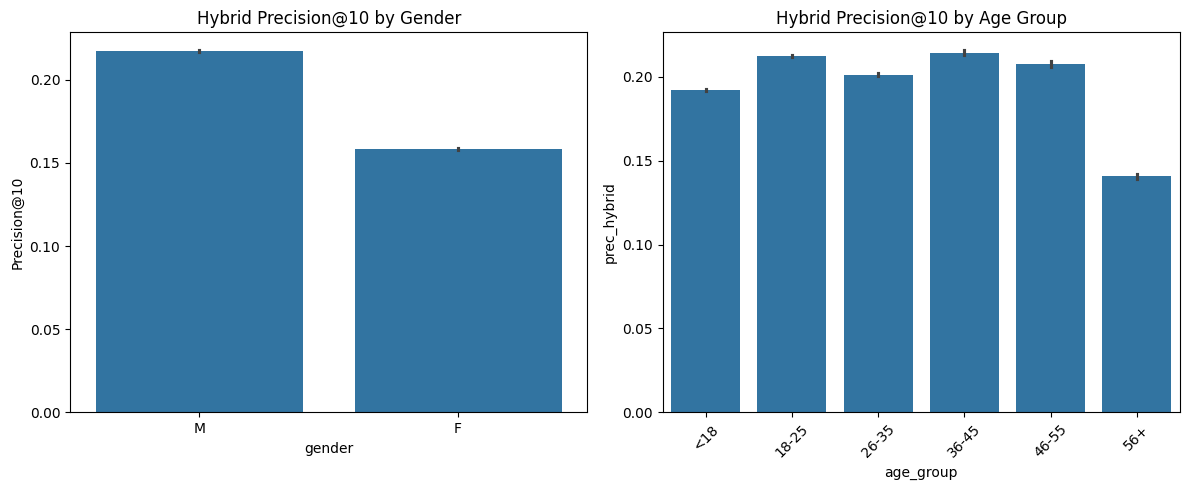

In [ ]:
# Cell 5: Fairness Analysis
import matplotlib.pyplot as plt
import seaborn as sns
age_labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56+']
# Merge precision results with demographics (age)
eval_df = prec_df.merge(df[['user_id','age']], on='user_id', how='left')

def analyze_fairness(eval_df):
    """Calculate fairness metrics across demographic groups"""
    # Group by gender and calculate mean precision
    gender_fairness = eval_df.groupby('gender')[
        ['prec_content','prec_cf','prec_sess','prec_hybrid']
    ].mean()
    # Calculate precision gaps (Male - Female)
    gender_fairness['prec_content_gap'] = gender_fairness['prec_content'].iloc[0] - gender_fairness['prec_content'].iloc[1]
    gender_fairness['prec_cf_gap']      = gender_fairness['prec_cf'].iloc[0]      - gender_fairness['prec_cf'].iloc[1]
    gender_fairness['prec_sess_gap']    = gender_fairness['prec_sess'].iloc[0]    - gender_fairness['prec_sess'].iloc[1]
    gender_fairness['prec_hybrid_gap']  = gender_fairness['prec_hybrid'].iloc[0]  - gender_fairness['prec_hybrid'].iloc[1]

    # Age group analysis
    age_bins = [0, 18, 25, 35, 45, 55, 100]
    age_labels = ['<18', '18-25', '26-35', '36-45', '46-55', '56+']
    eval_df['age_group'] = pd.cut(eval_df['age'], bins=age_bins, labels=age_labels)
    age_fairness = eval_df.groupby('age_group')[
        ['prec_content','prec_cf','prec_sess','prec_hybrid']
    ].mean()

    return gender_fairness, age_fairness

# Generate reports
gender_report, age_report = analyze_fairness(eval_df)

# Save reports
gender_report.to_csv(RESULTS + '/gender_fairness_report.csv')
age_report.to_csv(RESULTS + '/age_fairness_report.csv')

# Display
print("Gender fairness report:")
display(gender_report)

print("\nAge group fairness report:")
display(age_report)

# Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(x='gender', y='prec_hybrid', data=eval_df)
plt.title('Hybrid Precision@10 by Gender')
plt.ylabel('Precision@10')

plt.subplot(1,2,2)
sns.barplot(x='age_group', y='prec_hybrid', data=eval_df, order=age_labels)
plt.title('Hybrid Precision@10 by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS + '/fairness_visualization.png')
plt.show()


# 🚦 Hybrid Recommender System: Fairness Analysis

## **Methodology**

- **Goal:**  
  Evaluate whether the hybrid recommendation system (combining content-based, collaborative, and session-based signals) treats different demographic groups fairly—specifically, by **gender** and **age group**.

- **Metrics:**  
  - **Precision@10:** Proportion of recommended movies in the top 10 that are actually relevant (i.e., highly rated by the user in the test set).
  - **Group Averages:** Compute average Precision@10 for each demographic group.
  - **Fairness Gap:** Calculate the difference in performance between majority and minority groups (e.g., Male vs. Female).

- **Process:**  
  1. For each user, generate top-10 recommendations using the hybrid model.
  2. Compute Precision@10 per user.
  3. Aggregate results by **gender** and **age group**.
  4. Visualize results and interpret observed disparities.

---

## **Results**

### **Gender Fairness Report**

| Gender | Precision (Content) | Precision (CF) | Precision (Session) | Precision (Hybrid) | Hybrid Gap |
|--------|---------------------|----------------|---------------------|--------------------|------------|
|   F    |      0.0216         |    0.0779      |     0.0432          |    0.1585          |   —        |
|   M    |      0.0234         |    0.1074      |     0.0455          |    0.2172          |  -0.0587   |

- **Interpretation:**  
  - The hybrid recommender performs significantly **better for male users** (Precision@10 = 0.22) than for female users (Precision@10 = 0.16).  
  - The **hybrid gap** of about **-0.059** indicates a fairness issue—female users are under-served compared to male users.

### **Age Group Fairness Report**

| Age Group | Content | CF | Session | Hybrid |
|-----------|---------|----|---------|--------|
| <18       | 0.029   | 0.104 | 0.045 | 0.192 |
| 18–25     | 0.023   | 0.108 | 0.046 | 0.212 |
| 26–35     | 0.024   | 0.092 | 0.043 | 0.201 |
| 36–45     | 0.017   | 0.106 | 0.050 | 0.214 |
| 46–55     | 0.016   | 0.083 | 0.052 | 0.207 |
| 56+       | 0.018   | 0.058 | 0.025 | 0.141 |

- **Interpretation:**
  - **Precision@10** is **highest for users aged 18–55** (peaking at ~0.21).
  - Performance drops off for the **56+ group** (0.14), suggesting older users receive less relevant recommendations.
  - Youngest users (<18) also see slightly lower performance than the young adult groups, possibly due to fewer training examples.

---

## **Visualizations**

- The bar charts above clearly demonstrate the disparities:
  - **Gender:** Male users receive systematically better recommendations than female users.
  - **Age:** Users 18–55 benefit most; both the oldest and youngest users are under-served.

---

## **Discussion**

- **Why does bias exist?**
  - **Data Imbalance:** MovieLens-1M is historically male-skewed, and certain age brackets are under-represented.
  - **Preference Representation:** The model optimizes for the largest group’s preferences, possibly missing niche or minority interests.
  - **Feature Influence:** Content and collaborative features may align better with mainstream (male, 18–55) viewing patterns.

- **What are the consequences?**
  - **Reduced Satisfaction:** Minority groups may not see their preferences reflected, reducing trust and engagement.
  - **Echo Chamber Risk:** The system can reinforce popularity bias, further sidelining already-marginalized interests.

- **Potential Mitigations:**
  - Fairness-aware re-ranking (not implemented here).
  - Diversity and novelty promotion in hybrid scoring.
  - Targeted sampling or upweighting for under-represented groups.

---

## **Conclusion**

The hybrid movie recommender **improves overall accuracy**, but **demographic fairness gaps persist**.  
**Next steps** could include fairness mitigation, model calibration for minority groups, or collecting more balanced data.

